In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xmitgcm import open_mdsdataset
import pych.ecco as pe
import ecco_v4_py as ecco
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy import stats

from pych.plot import nice_inward_ticks

In [2]:
plt.rcParams.update({'font.size':18,'axes.labelsize':18,'axes.titlesize':22,'text.usetex':True})
rc('text.latex', preamble=r'\usepackage{color}')

### Load up the ECCO dataset

In [3]:
#dseu = xr.open_mfdataset(glob('/mnt/data/results/eccov4r4/nctiles_daily/uvelmass2/download_data.php?file=%2Feccodata%2Fllc_90%2FECCOv4%2FRelease4%2Fnctiles_daily%2FUVELMASS%2F2007*.nc'))
#dseu = dseu.isel(k=7)
#dsev = xr.open_mfdataset(glob('/mnt/data/results/eccov4r4/nctiles_daily/vvelmass/download_data.php?file=%2Feccodata%2Fllc_90%2FECCOv4%2FRelease4%2Fnctiles_daily%2FVVELMASS%2F2007*.nc'))
#dsev = dsev.isel(k=7)

In [4]:
#dseg= pe.read_mds('/workspace/grids/llc90',iters=None)
#dse = xr.merge([dseu,dsev,dseg],compat='override')

In [5]:
#lon=-140
#_,maskS = ecco.calc_section_trsp._parse_section_trsp_inputs(dse,[lon,.3],[lon,-.3],None,None,'EUC')

In [6]:
#lat=0
#maskW,_ = ecco.calc_section_trsp._parse_section_trsp_inputs(dse,[-141,lat],[-139,lat],None,None,'EUC')
#maskW2,_ = ecco.calc_section_trsp._parse_section_trsp_inputs(dse,[-141,lat-.3],[-139,lat-.3],None,None,'EUC')
#maskW3,_ = ecco.calc_section_trsp._parse_section_trsp_inputs(dse,[-141,lat+.3],[-139,lat+.3],None,None,'EUC')

In [7]:
#maskW = maskW1+maskW2+maskW3

In [8]:
#print('sum: maskW',maskW.sum().values)
#print('sum: maskS',maskS.sum().values)

In [9]:
#dse['uvel'] = .5*100*(maskS*dse.VVELMASS).sum(['tile','j_g','i'])
#dse['vvel'] = .5*100*(maskW*dse.UVELMASS).sum(['tile','j','i_g'])

### Load up ADCP dataset

In [10]:
adcp = xr.open_dataset('/mnt/data/datasets/tao_triton/adcp_xyzt_dy.cdf')
adcp = adcp.sel(lon=220,lat=0,depth=75).sel(time=slice('1997-01-01','2007-12-31'))
adcp = adcp.rename({'U_1205':'uvel','V_1206':'vvel'})

In [11]:
def replace_nans(ds,fld):
    ds[fld] = xr.where(ds[fld]==ds.missing_value,np.NAN,ds[fld])
    return ds[fld]

In [12]:
for f in adcp.data_vars:
    adcp[f] = replace_nans(adcp,f)

In [13]:
fake_for_xaxis = xr.where(np.isnan(adcp.uvel),0.,adcp.uvel)

In [14]:
tablestuff=[]
for fld in ['uvel','vvel']:
    # do some computations for table
    comps =  ['%.2f' % adcp[fld].mean().values,
              '%.2f' % adcp[fld].min().values,
              '%.2f' % adcp[fld].max().values,
              '%.2f' % adcp[fld].std().values,
              '%.2f' % stats.skew(adcp[fld].values,nan_policy='omit').data,
              '%.2f' % stats.kurtosis(adcp[fld].values,nan_policy='omit'),
              ''] # last for RMSD ... coming soon
    tablestuff.append(comps)

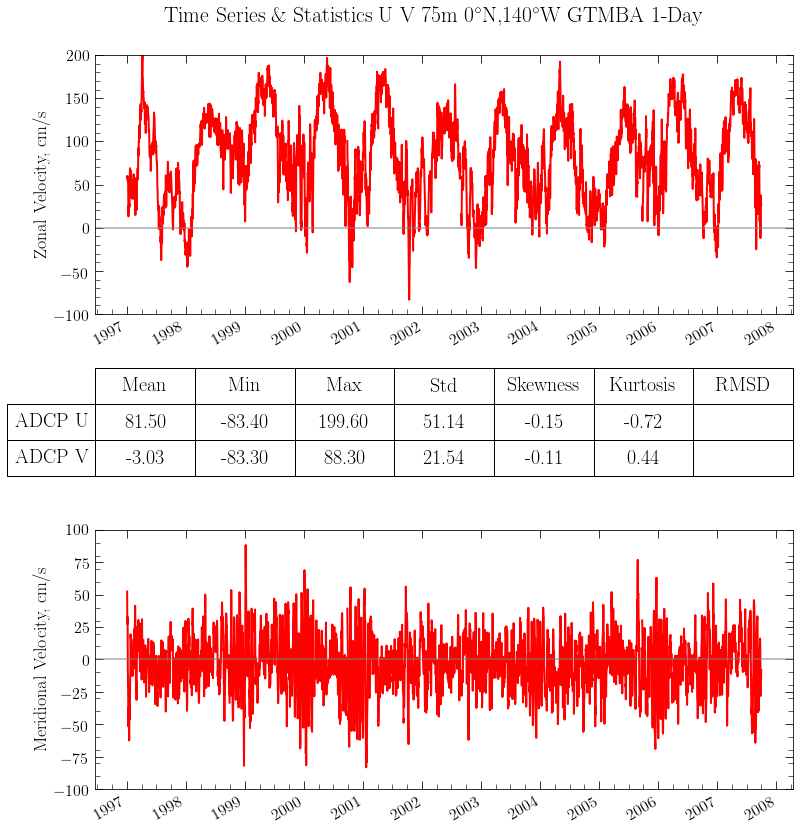

In [16]:
fig,axs = plt.subplots(3,1,figsize=(6.25*2,2.25*6),
                       gridspec_kw={
                           'height_ratios': [2,1, 2]})

for fld,ax,lbl,ylim in zip(['uvel','vvel'],
                           axs[[0,2]],
                           ['Zonal Velocity, cm/s','Meridional Velocity, cm/s'],
                          [[-100,200],[-100,100]]):
    adcp[fld].plot(ax=ax,color='red',label='GTMBA ADCP')

    # add line at y=0
    ax.axhline(y=0,alpha=.5,color='gray')
    
    # Plot formatting
    ax.set(xlabel='',ylabel=lbl,
           ylim=ylim,#xlim=["2006-12-15","2007-12-31"],
           title='')
    nice_inward_ticks(ax,yminor_skip=10)

    # Date formatting for x-axis
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4,7,10]))
    ax.xaxis.set_major_formatter(date_form)
    
columns = ['Mean','Min','Max','Std','Skewness','Kurtosis','RMSD']
table = axs[1].table(tablestuff,
             rowLabels=['ADCP U','ADCP V'],colLabels=columns,
             loc='center',rowLoc='center',cellLoc='center')
axs[1].axis('off')
table.set_fontsize(20)
table.scale(1, 3)

fig.suptitle(r'Time Series \& Statistics U V 75m 0$^\circ$N,140$^\circ$W GTMBA 1-Day',y=.93);
fig.savefig('/workspace/results/eccov4r4/equatorial-under-current/figures/adcp_140w_75m_1997-2007.png')